In [14]:
import numpy as np
import cv2
# import glob
import matplotlib.pyplot as plt
#%matplotlib qt

In [146]:
## camera calibration
## Here I use the code from ../examples/example.ipynb
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# Make a list of calibration images
# images = glob.glob('/Users/Victoria/udacity-git-course/CarND/LaneLines/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
## Lesson: use the ABSOLUTE path!
path = '/Users/Victoria/udacity-git-course/CarND/LaneLines/CarND-Advanced-Lane-Lines'
images = []
for i in range(1,21):
    img_path = path + '/camera_cal/calibration' + str(i) + '.jpg'
    img = cv2.imread(img_path)
    images.append(img)

# Step through the list and search for chessboard corners
for img in images:
#    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, images[0].shape[1::-1], None, None)

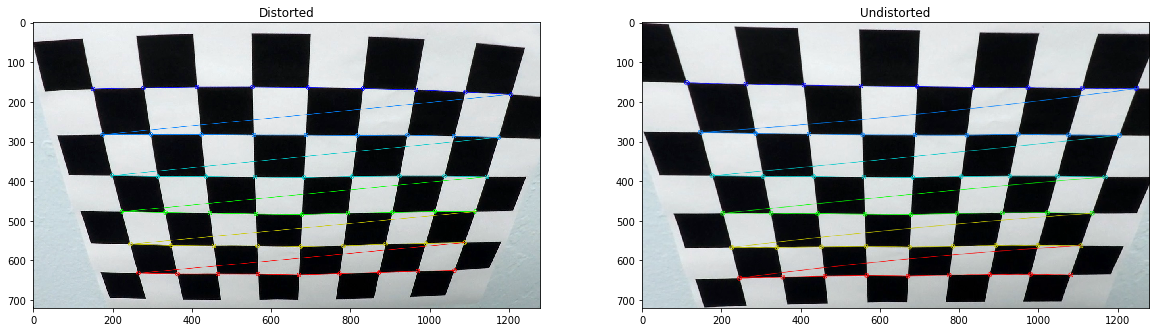

In [51]:
# test camera calibration
dst = cv2.undistort(images[1], mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Distorted')
ax1.imshow(images[1], cmap='gray')
ax2.set_title('Undistorted')
ax2.imshow(dst, cmap='gray')
plt.savefig(path + '/output_images/undistorted.png')

In [136]:
# Thresholding function
def thresh(img, kernel_size=5, sobel_thresh=(100,200), mag_thresh=(10,255), direc_thresh=(0.7,1.3), S_thresh=(90,255)):
    # Sobel function
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, kernel_size)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    mag = np.sqrt(sobelx**2 + sobely**2) # magnitude of gradients
    direc = np.arctan2(abs_sobely, abs_sobelx) # direction of gradients

    # Convert the absolute value image to 8-bit
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    scaled_mag = np.uint8(255*mag/np.max(mag))

    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sobel_thresh[0]) & (scaled_sobelx <= sobel_thresh[1])] = 1
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sobel_thresh[0]) & (scaled_sobely <= sobel_thresh[1])] = 1

    mag_binary = np.zeros_like(mag)
    mag_binary[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1

    direc_binary = np.zeros_like(direc)
    direc_binary[(direc >= direc_thresh[0]) & (direc <= direc_thresh[1])] = 1

    # HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    S_binary = np.zeros_like(S)
    S_binary[(S > S_thresh[0]) & (S <= S_thresh[1])] = 1

    # combine all conditions
    combined = np.zeros_like(S)
    combined[((sxbinary == 1) & (sybinary == 1)) | ((mag_binary == 1) & (direc_binary == 1)) & (S_binary == 1)] = 1
    
    return combined

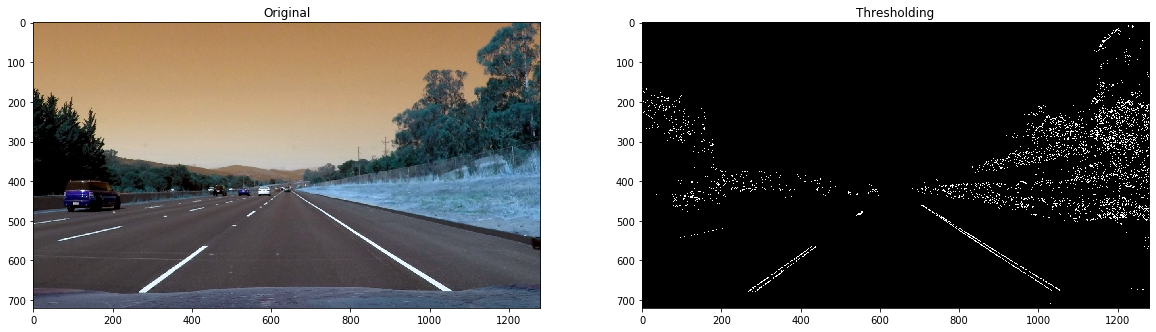

In [144]:
# Test thresholding
img = cv2.imread(path + '/test_images/straight_lines2.jpg')
# parameter: 15, (100,200), (10,255), (0.7,1.3), (90,255)
img_thresh = thresh(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(img, cmap='gray')
ax2.set_title('Thresholding')
ax2.imshow(img_thresh, cmap='gray')
plt.savefig(path + '/output_images/straight_lines2.png')

In [ ]:
# Perspective transform function
def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)

    return warped

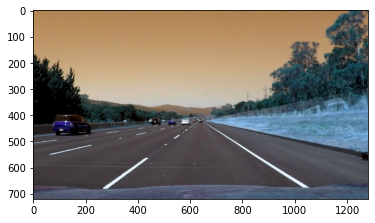

In [16]:
img = cv2.imread(path + '/test_images/straight_lines2.jpg')
plt.imshow(img)